In [9]:
using Pkg
Pkg.activate("NB06")

  Activating project at `~/Documents/Lehre/Uni Osnabrück/Math Methoden der Datenanalyse 2022/MathData-SoSe22/Notebooks/NB06`


In [10]:
using MLDatasets
using Plots, LinearAlgebra, StatsBase, Distributions
using Images, ImageCore
import Base.Iterators: product

*Warning:* For this notebook I had to pin `CSV.jl` to version 0.8.5, because otherwise `MLDatasets` would not compile. This restricts `MLDatasets` to version 0.5. The latest version has a different syntax than the one used here.

# Principal Component Analysis

In this notebook we will apply PCA to three datasets.


## Points on a circle


The first dataset is synthetic data generated from the unit circle $S^1 \subset \mathbb R^2$.

We want to use PCA to learn the geometry of the data.

Let us first generate $n=100$ random points on $S^1$ and add Gaussian noise with variance $\sigma^2 = 0.01$.

In [11]:
n = 100
σ² = 0.01
X = [[cos(ϕ); sin(ϕ)] + sqrt(σ²) .* randn(2) for ϕ in rand(0:0.1:2π, n)];

We center the data

In [12]:
x̄ = mean(X);
X = map(x -> x - x̄, X);

and plot the data.

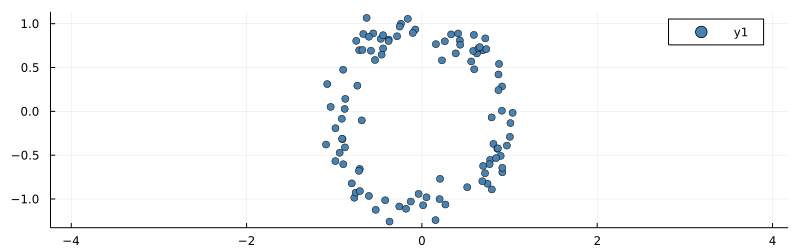

In [13]:
X_mat = hcat(X...);
scatter(X_mat[1,:], X_mat[2,:], 
        color = :steelblue, size = (800,250), aspect_ratio = :equal)

We suspect that there is a polynomial of degree 2 vanishing on the data set.

To detect this using PCA we introduce the feature map $\phi :\mathbb R^2 \to \mathbb R^6$ that sends $x$ to all monomials of degree at most 2 in $x$.

In [14]:
ϕ(x) = [1; x[1]; x[2]; x[1]*x[2]; x[1]^2; x[2]^2]

ϕ (generic function with 1 method)

The corresponding feature matrix is $\Omega$.

In [15]:
Ω = hcat(map(ϕ, X)...) |> transpose;

Let us compute a singular value decomposition of $\Omega$.

We extract the singular values in the array `svals`.

In [16]:
S = svd(Ω)
svals = S.S;

The normalized differences of the entries of `svals` are

In [17]:
diff(svals) ./ svals[2:end]

5-element Vector{Float64}:
 -0.673415237835637
 -0.07115503852359681
 -0.5017552465732357
 -0.17201275781845862
 -2.2211749338275766

It seems that there is significant gap when passing from the 5th to the 6th singular value.

Let us check the singular vector corresponding to the 6th singular value.

In [18]:
u = S.V[:, 6] 
f = round.(u ./ u[end], digits = 3)
println("$(f[1]) + $(f[2]) x₁ + $(f[3]) x₂ + $(f[4]) x₁x₂ + $(f[5]) x₁²+ $(f[6]) x₂²")

-1.093 + 0.059 x₁ + 0.176 x₂ + -0.005 x₁x₂ + 1.16 x₁²+ 1.0 x₂²


This is close to the actual equation $-1 + x_1^2 + x_2^2 = 0$.

# Geometry of Images

Let us next consider data from the [CIFAR10](http://www.cs.toronto.edu/~kriz/cifar.html) dataset.

In [19]:
data_X, data_Y = CIFAR10.traindata();

The dataset contains images of 10 classes of objects:

In [20]:
labels = ["airplane", 
          "automobile", 
          "bird", 
          "cat", 
          "deer", 
          "dog", 
          "frog", 
          "horse", 
          "ship", 
          "truck"];

Let us take the subsset consisting of images of trucks.

In [21]:
idx = findfirst(labels .== "truck") - 1
trucks = data_X[:,:,:, data_Y .== idx];

We now have 5000 images of trucks.

In [22]:
n_images = size(trucks, 4)

5000

Each image consists of $D=32 \cdot 32 \cdot 3 = 3072$ numerical values. 

They represent the RGB values of $32\times 32$ pixels.

Thus, we have data in $\mathbb R^D$.

In [23]:
D = 32 * 32 * 3

3072

Let us consider a subset $X$ of 500 data points.

In [24]:
n = 500
subsample = sample(1:n_images, n, replace = false)

X = map(subsample) do i
    xᵢ = vec(trucks[:,:,:,i])
    Float64.(xᵢ)
    end;

We normalize the data.

In [25]:
x̄ = mean(X);
stds = std(X);
X = map(x -> (x - x̄) ./ stds, X);

Let us take a look at a random subset of 6 images from our data.

,,,,,

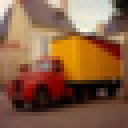
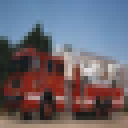
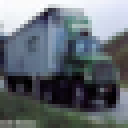
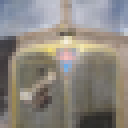
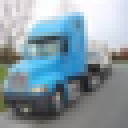
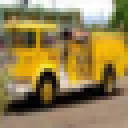

In [26]:
k = rand(subsample, 6)
[CIFAR10.convert2image(trucks[:,:,:,i]) for i in k]

We now want to see if there could be a polynomial equation of degree $k=4$ vanishing on the data.

For this, we define the kernel map.

In [27]:
k = 4
κ(x₁, x₂) = (x₁ ⋅ x₂ + 1)^k

κ (generic function with 1 method)

Next, we compute the matrix $R:=W^TW$ from the lecture notes.

In [28]:
e = ones(n);
P = diagm(e) - (1/n) .* (e*e');
G = [κ(x₁, x₂) for (x₁, x₂) in product(X,X)]

R = P * G * P;

We compute the eigenvalues of $R$

In [29]:
E = eigen(R);
evals = E.values;

and plot their normalized differences.

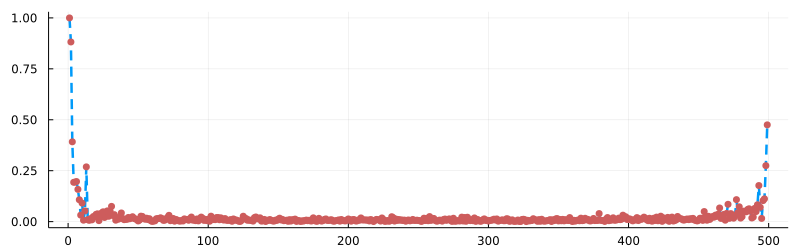

In [96]:
plot(diff(evals) ./ evals[2:end], legend = false, size = (800,250), linewidth = 2.5, linestyle = :dash)
scatter!(diff(evals) ./ evals[2:end], 
        markercolor = :indianred, markerstrokecolor = :indianred, markersize = 4)

The eigenvalues are increasing from left to right. 

We know that $R$ always has a kernel. This is the leftmost point on top.

In addition, we see more points on the left separating from the rest. 

This is an indicator that there could be indeed polynomial equations (approximately) vanishing on the data.

For instance, the trucks are photographed from different angles, so that the equation could describe rotational symmetry.

# Generative Models

We consider again the [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) dataset from [Zalando Research](https://github.com/zalandoresearch).

In [34]:
data_X, data_Y = FashionMNIST.traindata();

In [35]:
labels = ["T-shirt/top", 
            "Trouser", 
            "Pullover", 
            "Dress", 
            "Coat", 
            "Sandal", 
            "Shirt", 
            "Sneaker", 
            "Bag", 
            "Ankle boot"];

Let us consider the subset of the data consisting of images of sneakers.

In [36]:
idx = findfirst(labels .== "Sneaker") - 1
sneakers = data_X[:,:, data_Y .== idx];

This dataset contains 6000 images. 

In [37]:
n_images = size(sneakers, 3)

6000

We take a subset of $n=500$ images.

In [38]:
n = 500
subsample = sample(1:n_images, n, replace = false);

Let us take a look at 6 randomly chosen images from our dataset.

,,,,,

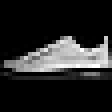
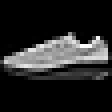
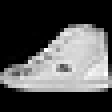
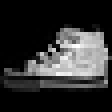
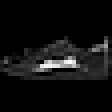
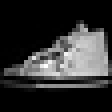

In [39]:
k = rand(subsample, 6)
[FashionMNIST.convert2image(sneakers[:,:,i]) for i in k]

We embed the data in $\mathbb R^D$ ($D= 28^2 = 784$ for $28\times 28$ pixels) and center the data.

In [40]:
D = 28^2

784

In [41]:
X = map(subsample) do i
    xᵢ = vec(sneakers[:,:,i])
    Float64.(xᵢ)
    end;

x̄ = mean(X);
X = map(x -> x .- x̄, X);

The feature matrix $\Omega$ in this case is simply the matrix having the data as rows.

In [42]:
Ω = hcat(X...) |> transpose;

Now, we compute a singular value decomposition of $\Omega$.

In [60]:
S = svd(Ω)
svals = S.S;

Let us plot the logarithms of the values in `svals`.

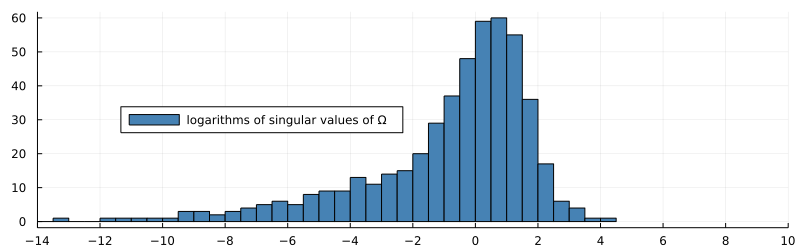

In [83]:
histogram(log.(svals), color = :steelblue, nbins = 100, size = (800,250), 
                     xticks = -14:2:10, xlims = (-14,10),
                     label = "logarithms of singular values of Ω", legend = (0.2,0.5))

It seems that the majority of singular values is below $\exp(2)$.

Let us choose the linear subspace that is spanned by all eigenvectors for eigenvalues $\lambda \geq \exp(x)$. 

In [67]:
λ = exp(2)
d = findfirst(svals .< λ)

30

We aim to approximate the data by a model $x = A\zeta + b + \epsilon$ of dimension, where $A\in\mathbb R^{D\times d}$ and

$$\epsilon \sim N(0,\sigma^2\mathbf{1}_D) \text{ and } \zeta \sim N(\nu, B)$$

If $\Omega = UDV^T$ we take $A$ to be the first $d$ columns of $V$ and $d=\bar{x}$.

In [68]:
A = S.V[:, 1:d];
b = x̄;

We also take $\sigma^2 = 0.001$, $\nu = 0$ and $C=2\mathbf 1_d$. 

This choice seems to work well.

In [71]:
σ² = 0.001
ν = zeros(d)
B = diagm(2 .* ones(d));

 We use the [Distributions.jl](https://juliastats.org/Distributions.jl/stable/) package to generate the distributions for $\epsilon$ and $\zeta$.

In [72]:
N_ζ = MvNormal(ν, B);
N_ϵ = MvNormal(zeros(D), diagm(σ² .* ones(D)));

Let us now use our model to generate synthetic data.

In [73]:
ζ = rand(N_ζ, 8)
ϵ = rand(N_ϵ, 8)
synthetic_data =[A * ζ[:,i] + b + ϵ[:,i] for i in 1:8];
synthetic_images = [reshape(u, 28, 28) for u in synthetic_data];

The array `synthetic_images` now contains 8 randomly chosen points from our model.

Let us display the corresponding pictures.

,,,,,,,

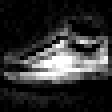
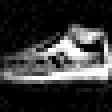
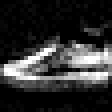
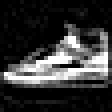
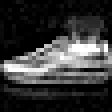
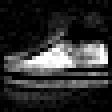
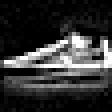
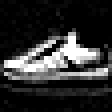

In [74]:
create_RGB_image(img) = [Gray(img[i,j]) for (i,j) in product(1:28, 1:28)]'
map(create_RGB_image, synthetic_images)

Finally, we use the distribution $N(\nu,B)$ as a prior to compute the distribution of $(\zeta \mid x)$, where $x$ is an additional data point outside of our subsample

In [75]:
testsample = setdiff(1:n_images, subsample);
j = rand(testsample)
x =  Float64.(vec(sneakers[:,:,j]));

Let us look at the image corresponding to `x`.

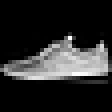

In [76]:
FashionMNIST.convert2image(sneakers[:,:,j])

In [ ]:
We use the formula for the posterior distribution

In [80]:
B⁻¹ = inv(B)
C = inv((1/σ²) .* diagm(ones(d)) + B⁻¹)
m = C * ((1/σ²) .* A' * (x - b) + B⁻¹ * ν);
N_ζ_posterior = MvNormal(m, C);

and use the posterior distribution for generating synthetic data again.

In [81]:
ζ = rand(N_ζ_posterior, 8)
ϵ = rand(N_ϵ, 8)
synthetic_data_2 =[A * ζ[:,i] + b + ϵ[:,i] for i in 1:8]
synthetic_images_2 = [reshape(u, 28, 28) for u in synthetic_data_2];

,,,,,,,

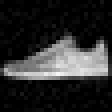
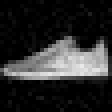
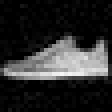
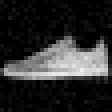
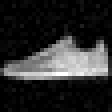
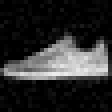
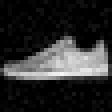
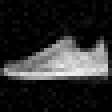

In [82]:
map(create_RGB_image, synthetic_images_2)